## Sweeping over a paramter range in HFSS 🧹

Analyzing the cavity is nice and all, but it very likely that you'll want to modify and optimize the cavity and it's properties for your needs. For this you can
simulate many different possibilities and choose the best paramters for you.

Let's say, for example, you want the coupling between the readout resonator and transmon would be around $1$ MHz, what should be the distance between them? Let's check!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyEPR as epr

plt.style.use('ggplot')
plt.style.use('seaborn-darkgrid')

#### 🔹 Connecting to HFSS

In [2]:
pinfo = epr.Project_Info(project_path = '.', 
                         project_name = 'DesignSimulations',  # File name
                         design_name  = 'CavityPinLength')

INFO 05:38PM [connect]: Connecting to Ansys Desktop API...
INFO 05:38PM [load_ansys_project]: 	File path to HFSS project found.
INFO 05:38PM [load_ansys_project]: 	Opened Ansys App
INFO 05:38PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 05:38PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    E:/CavityLocalSimulations/
	Project:   DesignSimulations
INFO 05:38PM [connect]: 	Opened active design
	Design:    CavityPinLength [Solution type: Eigenmode]
INFO 05:38PM [get_setup]: 	Opened setup `Setup1`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 05:38PM [connect]: 	Connection to Ansys established successfully. 😀 



#### 🧹 Sweep over the parameter

In [3]:
pin_length = pinfo.design.get_variable_value('feedthrough_pin_length')
print(pin_length)

14.605mm


In [4]:
%%time
swp_var = 'feedthrough_pin_length' 

def to_swp_val(x): return f'{x}mm' 

start = 14.605
stop = 24.105
step = 0.5
variations_vector = np.arange(start, stop+step, step)
for swp_param in variations_vector:
    swp_val = to_swp_val(swp_param)
    epr.logger.info(f'Setting sweep variable {swp_var}={swp_val}')
    pinfo.design.set_variable(swp_var, swp_val)
    pinfo.setup.analyze()

INFO 05:38PM [<module>]: Setting sweep variable feedthrough_pin_length=14.605mm
INFO 05:38PM [analyze]: Analyzing setup Setup1
INFO 05:39PM [<module>]: Setting sweep variable feedthrough_pin_length=15.105mm
INFO 05:39PM [analyze]: Analyzing setup Setup1
INFO 05:39PM [<module>]: Setting sweep variable feedthrough_pin_length=15.605mm
INFO 05:39PM [analyze]: Analyzing setup Setup1
INFO 05:39PM [<module>]: Setting sweep variable feedthrough_pin_length=16.105mm
INFO 05:39PM [analyze]: Analyzing setup Setup1
INFO 05:40PM [<module>]: Setting sweep variable feedthrough_pin_length=16.605mm
INFO 05:40PM [analyze]: Analyzing setup Setup1
INFO 05:40PM [<module>]: Setting sweep variable feedthrough_pin_length=17.105mm
INFO 05:40PM [analyze]: Analyzing setup Setup1
INFO 05:40PM [<module>]: Setting sweep variable feedthrough_pin_length=17.605mm
INFO 05:40PM [analyze]: Analyzing setup Setup1
INFO 05:41PM [<module>]: Setting sweep variable feedthrough_pin_length=18.105mm
INFO 05:41PM [analyze]: Analyzi

#### 🔹 Distributed Analysis (not quantum)

In [5]:
eprh = epr.DistributedAnalysis(pinfo)


Design "CavityPinLength" info:
	# eigenmodes    3
	# variations    20


Here we plot the quality factors of the transmon and readout resonator modes versus the variation number.
We can also check the exact numbers.

Variation number 0: 
        Freq. (GHz)  Quality Factor
mode                             
0        4.368958    6.508614e+09
1        6.499695    1.235186e+08
2        6.503123    2.663814e+08
Variation number 1: 
        Freq. (GHz)  Quality Factor
mode                             
0        4.368552    6.039605e+08
1        6.501626    3.416306e+07
2        6.503718    1.096164e+08
Variation number 2: 
        Freq. (GHz)  Quality Factor
mode                             
0        4.369535    8.705034e+07
1        6.501617    1.866760e+09
2        6.503497    1.300816e+08
Variation number 3: 
        Freq. (GHz)  Quality Factor
mode                             
0        4.369980    1.495537e+08
1        6.499681    9.186909e+08
2        6.501656    7.380850e+07
Variation number 4: 
        Freq. (GHz)  Quality Factor
mode                             
0        4.369589    4.952007e+07
1        6.501806    7.421924e+07
2        6.504118    3.889809e+08
Variation number 5: 
        Freq. 

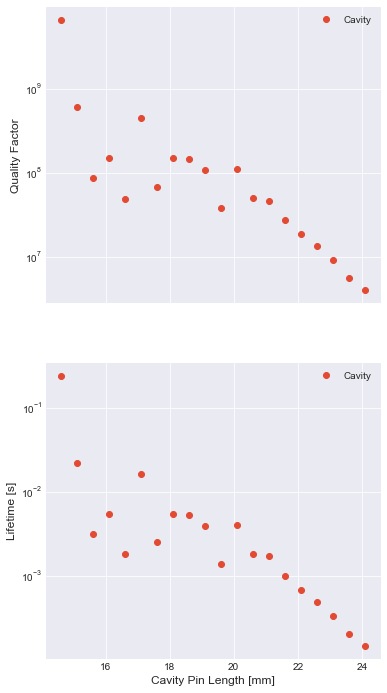

In [10]:
cavity_mode = 0
Qs_cav, freqs_cav = [], []

for variation in range(len(variations_vector)):
    try:
        print('Variation number {}: \n '.format(variation), eprh.get_freqs_bare_pd(variation=str(variation)) )
        Qs_cav.append(eprh.get_freqs_bare_pd(variation=str(variation)).iloc[cavity_mode]['Quality Factor'])
        freqs_cav.append(eprh.get_freqs_bare_pd(variation=str(variation)).iloc[cavity_mode]['Freq. (GHz)'])
    except Exception as e:
        print ('Error in variation', variation, e)
        variations_vector = np.delete(variations_vector, variation)
        continue

taus_cav = np.array(Qs_cav) / (2 * np.pi * np.array(freqs_cav) * 1e9)

fig, axs = plt.subplots(2, 1, figsize=(6, 12), sharex = True)

#Quality factors plot
axs[0].plot(variations_vector, Qs_cav, 'o', label = 'Cavity')
axs[0].set_ylabel('Quality Factor')

#Lifetimes plot
axs[1].plot(variations_vector, taus_cav, 'o', label = 'Cavity')
axs[1].set_ylabel( 'Lifetime [s]')

axs[0].set_yscale('log')
axs[0].legend()
axs[1].set_yscale('log')
axs[1].set_xlabel('Cavity Pin Length [mm]')
axs[1].legend()


fig.savefig(f'Figures/{pinfo.design_name}.png', dpi = None, bbox_inches='tight')
print('Variations vector:', variations_vector)
print('Cavity lifetimes:', taus_cav*1, 's')

In [18]:
pd.DataFrame([Qs_cav, taus_cav], columns = variations_vector, index = ['Quality Factor', 'Lifetimes [s]'])

,14.605,15.105,15.605,16.105,16.605,17.105,17.605,18.105,18.605,19.105,19.605,20.105,20.605,21.105,21.605,22.105,22.605,23.105,23.605,24.105
Quality Factor,6.508614e+09,6.039605e+08,8.705034e+07,1.495537e+08,4.952007e+07,4.507029e+08,6.876081e+07,1.515979e+08,1.460799e+08,1.073283e+08,3.835024e+07,1.112385e+08,4.968193e+07,4.689417e+07,2.721953e+07,1.854886e+07,1.341162e+07,9.240537e+06,5.620401e+06,4.051501e+06
Lifetimes [s],2.370996e-01,2.200347e-02,3.170701e-03,5.446754e-03,1.803686e-03,1.641793e-02,2.504643e-03,5.521402e-03,5.321000e-03,3.909017e-03,1.397003e-03,4.050793e-03,1.809245e-03,1.707806e-03,9.913794e-04,6.754127e-04,4.883106e-04,3.364787e-04,2.046822e-04,1.475234e-04
